# Programming Assignment (20 points)

Explore  different hyper-parameters of MLP in the context of Spam Detection. Feel free to use the lab ipynb as a whole thing, although we encourage you to extend it in any way. Your work consist of two major parts:

1.  (10 points) Investigate different options to train Word2Vec model.  Do at least 2 from the following list:  embedding dimension, minimum frequency, number of training epochs. Define some set of word pairs which you can use as a similarity arguments. Make some conclusions/observations.

2.  (10 points) Investigate different network architectures and hyper-parameters. Do at least  4 from  the following  list:  number  of layers,  number of  hidden units, number of epochs, early stopping criteria, learning rate, oversampling ratio, datapre-processing (check the first part). Since we care about false positives a lot (spam filter classifying normal emails as spam IS a bad filter!), simple accuracy term is not the best option.  To get full points for this task you need to compute precision / recall scores.

In [1]:
# the model design is adapted from Piotr Skalski code. 
# https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb

## Outline:

1. Working on toy double moon data and crafting multi-layer perceptron

2. Implementing a simple spam detector using SMS SPAM Dataset

In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline


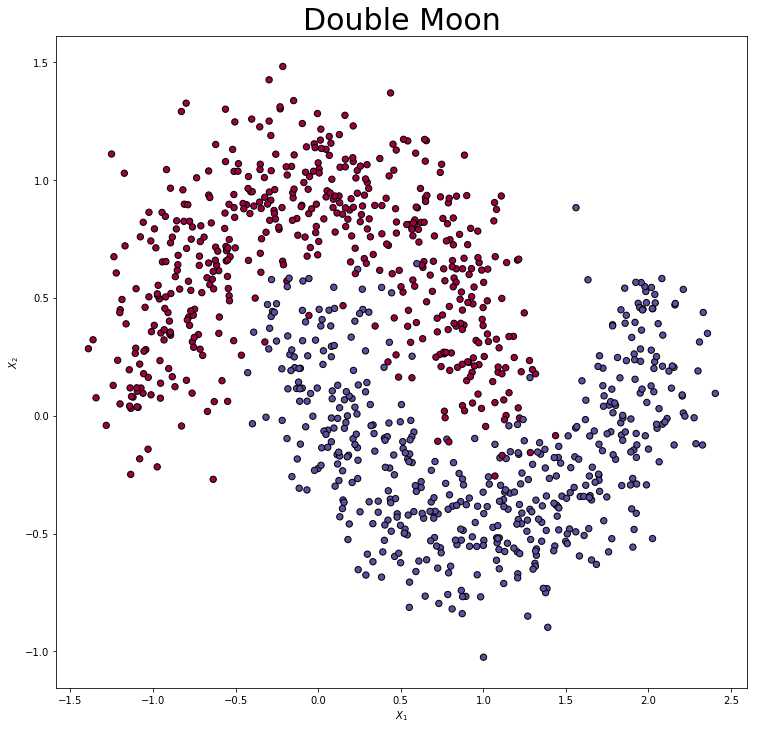

In [3]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

# Double moon dataset
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
        
make_plot(X, y, "Double Moon")

# Multi-layer Perceptron

1. Affine aka fully-connected layers
2. ReLU, Sigmoid activation functions
3. Backpropagation for the parameters update

## Layer initialization

In this function we initialize all trainable parameters of the MLP model.

`nn_architecture` is a list of dictionaries with layer specification.

`seed` defines the random seed for all initial parameters.

In [4]:
def init_layers(nn_architecture, seed = 42):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

## Activation functions

1. Sigmoid function -- we all know it already.

In [5]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

2. ReLU - Rectified Linear Unit. This is a piece-wise linear function. Got huge attention starting from legendary ImageNet 2012 paper.

In [6]:
def relu(Z):
    return np.maximum(0,Z)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

## Fully-connected layer execution

We have done this already for Logistic Regression lab and in Multiclass classfication lab.

## $$ Z_{l} = W_{l}A_{l-1} + b_{l} $$

`full_forward_propagation` defines the loop over layers with sequential execution, i.e. we go over DAG of computations.

In [7]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr


def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

## Cost computation

Our favorite LogReg loss! Nothing really new here.

## $$ L = -\frac{1}{m} (Y \log{\hat{Y}}^T + (1-Y)\log{(1 - \hat{Y})}^T) $$

In [8]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

## Computing the gradients --- Backpropagation

In [9]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Making an update --- (Stochastic) Gradient Descend

In [10]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

## Training loop

In [11]:
def train(X, Y, nn_architecture, epochs, learning_rate, batch_size=128, verbose=False, callback=None, spam_ids=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    num_samples = X.shape[1]
    num_minibatches = int(X.shape[1] / batch_size)
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        for j in range(num_minibatches):
            # step forward
            inds = np.random.choice(X.shape[1], batch_size // 2)
            if spam_ids is not None:
                # oversampling minor class
                inds_spam = np.random.choice(spam_ids.shape[0], batch_size // 2)
                inds_spam = spam_ids[inds_spam]
                inds = np.concatenate((inds, inds_spam))
            Y_hat, cashe = full_forward_propagation(X[:,inds], params_values, nn_architecture)

            # step backward - calculating gradient
            grads_values = full_backward_propagation(Y_hat, Y[:, inds], cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        if(i % 10 == 0):
            # calculating metrics and saving them in history
            cost = get_cost_value(Y_hat, Y[:,inds])
            accuracy = get_accuracy_value(Y_hat, Y[:, inds])
            cost_history.append(cost)
            accuracy_history.append(accuracy)

            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history

# 1. Double moon classification

Firstly we define the architecture of our network

In [12]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

In [13]:
import ipdb
# Training
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 1000, 0.01, batch_size=64, verbose=True)

Iteration: 00000 - cost: 0.69146 - accuracy: 0.62500
Iteration: 00010 - cost: 0.69484 - accuracy: 0.40625
Iteration: 00020 - cost: 0.69571 - accuracy: 0.40625
Iteration: 00030 - cost: 0.68981 - accuracy: 0.62500
Iteration: 00040 - cost: 0.69295 - accuracy: 0.46875
Iteration: 00050 - cost: 0.69118 - accuracy: 0.53125
Iteration: 00060 - cost: 0.68947 - accuracy: 0.62500
Iteration: 00070 - cost: 0.69106 - accuracy: 0.50000
Iteration: 00080 - cost: 0.68762 - accuracy: 0.62500
Iteration: 00090 - cost: 0.69082 - accuracy: 0.43750
Iteration: 00100 - cost: 0.68871 - accuracy: 0.53125
Iteration: 00110 - cost: 0.68661 - accuracy: 0.71875
Iteration: 00120 - cost: 0.68731 - accuracy: 0.81250
Iteration: 00130 - cost: 0.68412 - accuracy: 0.93750
Iteration: 00140 - cost: 0.68094 - accuracy: 0.87500
Iteration: 00150 - cost: 0.67805 - accuracy: 0.78125
Iteration: 00160 - cost: 0.66369 - accuracy: 0.81250
Iteration: 00170 - cost: 0.64660 - accuracy: 0.90625
Iteration: 00180 - cost: 0.62356 - accuracy: 0

## Some plots

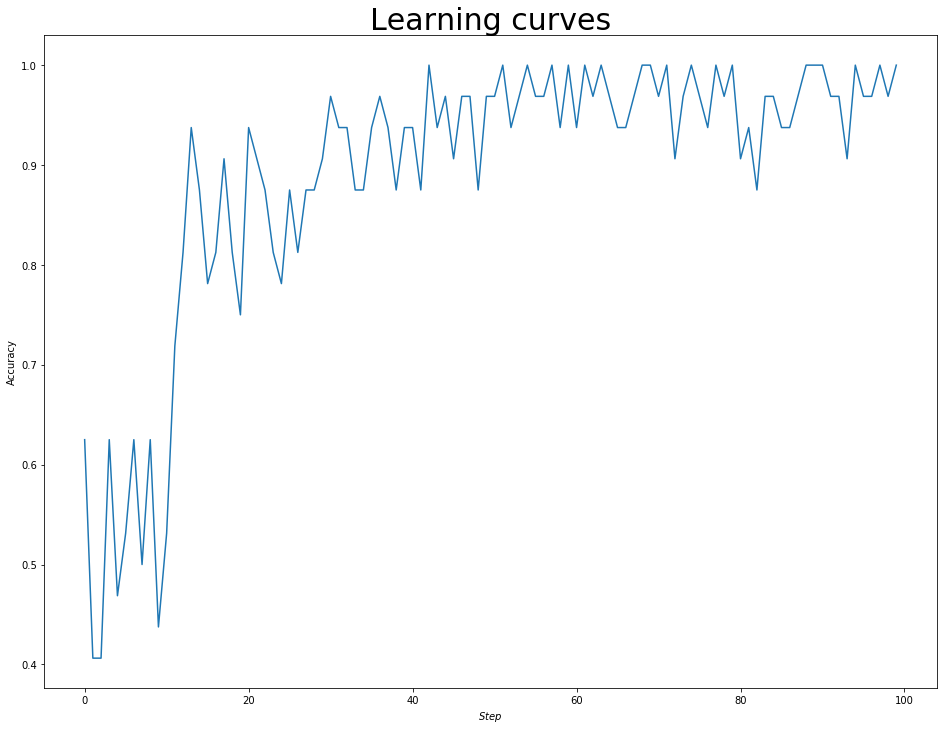

In [14]:
def simple_plot(metric, name):
    x_axis = np.arange(len(metric))
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Step$", ylabel=name)
    plt.title("Learning curves", fontsize=30)
    plt.plot(x_axis, np.array(ah))
    plt.show

simple_plot(ah, 'Accuracy')

In [15]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [16]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [17]:
acc_test

0.99

# Text classification

In [18]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# install nltk if needed
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
stemmer = SnowballStemmer("english")

In [19]:
import nltk
# nltk.download('punkt')

## Text classification: variable length input!

In [20]:
# lets load some data first

spam_data = pickle.load(open('spam.pkl', 'rb'))
spam_data_input = [i[0] for i in spam_data]
cleaned_spam_data_input = []
one_line_data = []
for sent in spam_data_input:
    toked = word_tokenize(sent)
    stemmed = []
    for token in toked:
        stemmed.append(stemmer.stem(token))
    cleaned_spam_data_input.append(' '.join(stemmed))
    one_line_data.append(stemmed)
    

spam_data_label = [i[1] for i in spam_data]

_X_train, _X_test, _y_train, _y_test = train_test_split(cleaned_spam_data_input, spam_data_label)

## Lets check some examples

In [21]:
for i in range(10): print("{} - {}".format(_y_train[i], _X_train[i]))

1 - you have won a guarante £200 award or even £1000 cashto claim ur award call free on 08000407165 ( 18+ ) 2 stop getstop on 88222 php . rg21 4jx
0 - , how 's thing ? just a quick question .
0 - i 'm at home . pleas call
0 - good morn princess ! have a great day !
0 - whi did n't u call on your lunch ?
0 - finish alreadi ... yar they keep say i mushi ... i so embarrass ok ...
0 - greet me , ! consid yourself excus .
1 - 88066 from 88066 lost 3pound help
0 - to the wonder okor , have a great month . we cherish you guy and wish you well each day . mojibiola
0 - hi dear call me it urgnt . i do n't know what your problem . you do n't want to work or if you have ani other problem at least tell me . wate for your repli .


## Quick intro to Word2Vec

Relevant links:
https://radimrehurek.com/gensim/models/word2vec.html

original paper:
https://arxiv.org/pdf/1310.4546.pdf


In [38]:
import gensim 
from gensim.models import Word2Vec

#Original version
vectors_0 = Word2Vec(one_line_data, min_count=0)
vectors_0.train(cleaned_spam_data_input, total_examples=len(cleaned_spam_data_input), epochs=10)
vecs_0 = vectors_0.wv

## Lets check some word similarities

In [45]:
def get_word_similarity(s, vectors):
    print('sim({}) = {}'.format(s, vectors.similarity(s.split()[0], s.split()[1])))

### Task 1

(10 points) Investigate different options to train Word2Vec model. Do at least 2 from the following list: embedding dimension, minimum frequency, number of training epochs. Define some set of word pairs which you can use as a similarity arguments. Make some conclusions/observations.

In [47]:
print(vecs_0.vocab)

{'go': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376ba8>, 'until': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376b70>, 'jurong': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376b38>, 'point': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376128>, ',': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376ac8>, 'crazy..': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376a90>, 'avail': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376a58>, 'onli': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376a20>, 'in': <gensim.models.keyedvectors.Vocab object at 0x7f2a683769e8>, 'bugi': <gensim.models.keyedvectors.Vocab object at 0x7f2a683769b0>, 'n': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376978>, 'great': <gensim.models.keyedvectors.Vocab object at 0x7f2a68376940>, 'world': <gensim.models.keyedvectors.Vocab object at 0x7f2a683765c0>, 'la': <gensim.models.keyedvectors.Vocab object at 0x7f2a683768d0>, 'e': <gensim.models.keyedvectors.Vo

### Training model in different ways

We change the parameters for min_count and number of epochs in an increasing fashion an will see if the hypotheses above seem to hold.

In [48]:
# Version 1
vectors_1 = Word2Vec(one_line_data, min_count=3)
vectors_1.train(cleaned_spam_data_input, total_examples=len(cleaned_spam_data_input), epochs=10)
vecs_1 = vectors_1.wv

In [49]:
# Version 2
vectors_2 = Word2Vec(one_line_data, min_count=5)
vectors_2.train(cleaned_spam_data_input, total_examples=len(cleaned_spam_data_input), epochs=10)
vecs_2 = vectors_2.wv

In [50]:
# Version 3
vectors_3 = Word2Vec(one_line_data, min_count=0)
vectors_3.train(cleaned_spam_data_input, total_examples=len(cleaned_spam_data_input), epochs=30)
vecs_3 = vectors_3.wv

In [51]:
# Version 4
vectors_4 = Word2Vec(one_line_data, min_count=0)
vectors_4.train(cleaned_spam_data_input, total_examples=len(cleaned_spam_data_input), epochs=50)
vecs_4 = vectors_4.wv

In [62]:
strings = ['dog urgnt', 'chicken roast', 'death ruin', 'haunt christmassi']

print('Version 0')  
get_word_similarity('dog urgnt', vectors_0) ## original pair, unsure what to expect
get_word_similarity('chicken roast', vectors_0) ## Should be constanlty similar, as in the original model as seen below
get_word_similarity('death ruin', vectors_0) ## Should be constanlty similar, as in the original model as seen below
get_word_similarity('haunt christmassi', vectors_0) ## Should be constanlty disimilar, as in the original model as seen below

print() 
print('Version 1')
for s in strings:
    try:
        get_word_similarity(s, vectors_1)
    except:
        print('Not enough frequency')

print()
print('Version 2')
for s in strings:
    try:
        get_word_similarity(s, vectors_2)
    except:
        print('Not enough frequency')

print()
print('Version 3') 
for s in strings:
    try:
        get_word_similarity(s, vectors_3)
    except:
        print('Not enough frequency')

print()
print('Version 4')
for s in strings:
    try:
        get_word_similarity(s, vectors_3)
    except:
        print('Not enough frequency')

Version 0
sim(dog urgnt) = 0.6507207155227661
sim(chicken roast) = 0.9820318818092346
sim(death ruin) = 0.9813173413276672
sim(haunt christmassi) = -0.10077612102031708

Version 1
sim(dog urgnt) = 0.8891031742095947
sim(chicken roast) = 0.9437243938446045
sim(death ruin) = 0.9774598479270935
Not enough frequency

Version 2
sim(dog urgnt) = 0.9413906335830688
Not enough frequency
Not enough frequency
Not enough frequency

Version 3
sim(dog urgnt) = 0.5982373356819153
sim(chicken roast) = 0.9801578521728516
sim(death ruin) = 0.9805096387863159
sim(haunt christmassi) = -0.20599976181983948

Version 4
sim(dog urgnt) = 0.5982373356819153
sim(chicken roast) = 0.9801578521728516
sim(death ruin) = 0.9805096387863159
sim(haunt christmassi) = -0.20599976181983948


/home/student/miniconda3/envs/introml/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [63]:
print(len(cleaned_spam_data_input))

5574


We can see very little quantitative difference in the models we train. From version 0 to 1, we slightly increase the min_count, and this has an apparent normalizing effect in which we get the expected outcomes but with less extreme values. The last pair of words has a member without enough frequency in this case (even though the threshold is small).
Increasing the min_count even further to 5 has a very noticeable effect, as only the first pair remains in the vocabulary. This tells us that the training data size is small, and we confirm it above by noticing there are only 5574 data points. The similarity between dog and urgnt increases steadily, which is most likely due to the fact that there are much less words in the vocabulary now.

Increasing the number of training epochs to 30 has a slight effect, it does seem to retain appropiate values for very similar and very disimilar pairs, and seems to better generalize and gives dog urgnt less similarity. However, with this small experiment that is just a hypothesis. Increasing the epochs further doesn't change a thing, possibly because after 30 the model is as optimized as it can be, or it takes too many epochs to improve by a very small amount.



### Task 2

(10 points) Investigate different network architectures and hyper-parameters. Do at least 4 from the following list: number of layers, number of hidden units, number of epochs, early stopping criteria, learning rate, oversampling ratio, datapre-processing (check the first part). Since we care about false positives a lot (spam filter classifying normal emails as spam IS a bad filter!), simple accuracy term is not the best option. To get full points for this task you need to compute precision / recall scores.

In [26]:
WORD_EMB_DIM = 300
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 128, "activation": "sigmoid"},
    {"input_dim": 128, "output_dim": 128, "activation": "sigmoid"},
    {"input_dim": 128, "output_dim": 1, "activation": "sigmoid"},
]

## Convert text input data into the bag of words

Simply speaking, we take fixed dim embedding of every token in the sentence and average them all!

In [27]:
vector_based_spam_input = []
for sent in one_line_data:
    _tmp = []
    for w in sent:
        try:
            _tmp.append(vecs.get_vector(w))
        except:
            pass
    if len(_tmp) == 0:
        import ipdb; ipdb.set_trace()
    _avg = np.array(_tmp).mean(0)
    vector_based_spam_input.append(_avg)

In [28]:
print(cleaned_spam_data_input[3324])
print(vector_based_spam_input[3324])

she said , '' do u mind if i go into the bedroom for a minut ? `` 'ok '' , i sed in a sexi mood . she came out 5 minut latr wid a cake ... n my wife ,
[-6.00454211e-01  8.38390961e-02  1.74757093e-01 -5.85697651e-01
  2.49564014e-02 -5.21217525e-01 -3.54723662e-01  8.42788041e-01
 -3.67595822e-01 -7.68426061e-02  3.93384576e-01 -1.69428110e-01
  7.13280797e-01 -7.30573982e-02  1.34391896e-03 -6.06742859e-01
 -6.86936796e-01  5.05169332e-01  6.01948425e-03  1.19820797e+00
  9.81792957e-02  5.15078425e-01  3.41921479e-01  2.01463178e-01
  1.18979216e-01  2.08076593e-02 -4.04470801e-01 -3.66607308e-01
 -5.50931215e-01 -3.18487167e-01  1.21369667e-01  1.41356543e-01
 -5.92860103e-01 -1.62537605e-01  2.04129517e-01 -7.94015080e-02
 -3.56638402e-01  2.40067571e-01  4.03652787e-01  6.30188882e-01
 -1.55633658e-01  7.18051076e-01 -3.07980832e-02  4.15671021e-01
 -7.19038397e-02  1.31704986e-01 -5.21735370e-01  7.86189139e-01
  2.10954592e-01 -2.00956851e-01 -5.90389252e-01 -9.27687064e-02
  1.

In [29]:
_X_train, _X_test, _y_train, _y_test = train_test_split(vector_based_spam_input, spam_data_label)

In [30]:
X_train = np.array(_X_train)
X_test = np.array(_X_test)
y_train = np.array(_y_train)
y_test = np.array(_y_test)

y_train_spam_ids = (y_train == 1).nonzero()[0]

In [31]:
WORD_EMB_DIM = X_train.shape[1]
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

In [32]:
import ipdb
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=10000, learning_rate=0.01, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.69473 - accuracy: 0.35742
Iteration: 00010 - cost: 0.69021 - accuracy: 0.56055
Iteration: 00020 - cost: 0.68809 - accuracy: 0.56055
Iteration: 00030 - cost: 0.68875 - accuracy: 0.55273
Iteration: 00040 - cost: 0.68769 - accuracy: 0.55664
Iteration: 00050 - cost: 0.68385 - accuracy: 0.57227
Iteration: 00060 - cost: 0.68959 - accuracy: 0.54883
Iteration: 00070 - cost: 0.68394 - accuracy: 0.57031
Iteration: 00080 - cost: 0.68415 - accuracy: 0.57031
Iteration: 00090 - cost: 0.68288 - accuracy: 0.57422
Iteration: 00100 - cost: 0.68659 - accuracy: 0.55859
Iteration: 00110 - cost: 0.68767 - accuracy: 0.55469
Iteration: 00120 - cost: 0.68207 - accuracy: 0.57422
Iteration: 00130 - cost: 0.68342 - accuracy: 0.57031
Iteration: 00140 - cost: 0.68504 - accuracy: 0.56445
Iteration: 00150 - cost: 0.68825 - accuracy: 0.55078
Iteration: 00160 - cost: 0.68627 - accuracy: 0.55859
Iteration: 00170 - cost: 0.68370 - accuracy: 0.56836
Iteration: 00180 - cost: 0.67739 - accuracy: 0

Iteration: 01550 - cost: 0.58618 - accuracy: 0.76758
Iteration: 01560 - cost: 0.59149 - accuracy: 0.77539
Iteration: 01570 - cost: 0.60147 - accuracy: 0.75195
Iteration: 01580 - cost: 0.60110 - accuracy: 0.77344
Iteration: 01590 - cost: 0.58236 - accuracy: 0.77148
Iteration: 01600 - cost: 0.58466 - accuracy: 0.78906
Iteration: 01610 - cost: 0.59934 - accuracy: 0.76367
Iteration: 01620 - cost: 0.56551 - accuracy: 0.77734
Iteration: 01630 - cost: 0.56236 - accuracy: 0.80469
Iteration: 01640 - cost: 0.59122 - accuracy: 0.77539
Iteration: 01650 - cost: 0.57533 - accuracy: 0.76953
Iteration: 01660 - cost: 0.59470 - accuracy: 0.78906
Iteration: 01670 - cost: 0.60475 - accuracy: 0.75781
Iteration: 01680 - cost: 0.56697 - accuracy: 0.79492
Iteration: 01690 - cost: 0.56048 - accuracy: 0.80078
Iteration: 01700 - cost: 0.55127 - accuracy: 0.78320
Iteration: 01710 - cost: 0.58118 - accuracy: 0.79883
Iteration: 01720 - cost: 0.59701 - accuracy: 0.77148
Iteration: 01730 - cost: 0.54346 - accuracy: 0

Iteration: 03110 - cost: 0.48901 - accuracy: 0.77734
Iteration: 03120 - cost: 0.48093 - accuracy: 0.78906
Iteration: 03130 - cost: 0.45538 - accuracy: 0.80078
Iteration: 03140 - cost: 0.48474 - accuracy: 0.80078
Iteration: 03150 - cost: 0.46412 - accuracy: 0.80078
Iteration: 03160 - cost: 0.45626 - accuracy: 0.80273
Iteration: 03170 - cost: 0.50245 - accuracy: 0.77344
Iteration: 03180 - cost: 0.49125 - accuracy: 0.77148
Iteration: 03190 - cost: 0.47376 - accuracy: 0.79297
Iteration: 03200 - cost: 0.43830 - accuracy: 0.82617
Iteration: 03210 - cost: 0.47148 - accuracy: 0.78711
Iteration: 03220 - cost: 0.48741 - accuracy: 0.78125
Iteration: 03230 - cost: 0.48587 - accuracy: 0.78906
Iteration: 03240 - cost: 0.46861 - accuracy: 0.76953
Iteration: 03250 - cost: 0.45937 - accuracy: 0.79492
Iteration: 03260 - cost: 0.47801 - accuracy: 0.78320
Iteration: 03270 - cost: 0.44618 - accuracy: 0.80859
Iteration: 03280 - cost: 0.42373 - accuracy: 0.80664
Iteration: 03290 - cost: 0.48836 - accuracy: 0

Iteration: 04670 - cost: 0.41360 - accuracy: 0.81250
Iteration: 04680 - cost: 0.45092 - accuracy: 0.80078
Iteration: 04690 - cost: 0.42894 - accuracy: 0.82617
Iteration: 04700 - cost: 0.43464 - accuracy: 0.80078
Iteration: 04710 - cost: 0.40260 - accuracy: 0.84180
Iteration: 04720 - cost: 0.40003 - accuracy: 0.83594
Iteration: 04730 - cost: 0.37376 - accuracy: 0.85156
Iteration: 04740 - cost: 0.38174 - accuracy: 0.85742
Iteration: 04750 - cost: 0.42037 - accuracy: 0.83008
Iteration: 04760 - cost: 0.38820 - accuracy: 0.84180
Iteration: 04770 - cost: 0.39209 - accuracy: 0.83398
Iteration: 04780 - cost: 0.42703 - accuracy: 0.80273
Iteration: 04790 - cost: 0.37650 - accuracy: 0.84961
Iteration: 04800 - cost: 0.39958 - accuracy: 0.83594
Iteration: 04810 - cost: 0.43904 - accuracy: 0.81641
Iteration: 04820 - cost: 0.39147 - accuracy: 0.83789
Iteration: 04830 - cost: 0.41018 - accuracy: 0.83203
Iteration: 04840 - cost: 0.43455 - accuracy: 0.80664
Iteration: 04850 - cost: 0.38927 - accuracy: 0

Iteration: 06230 - cost: 0.38511 - accuracy: 0.83203
Iteration: 06240 - cost: 0.38343 - accuracy: 0.83594
Iteration: 06250 - cost: 0.38457 - accuracy: 0.83594
Iteration: 06260 - cost: 0.39492 - accuracy: 0.84375
Iteration: 06270 - cost: 0.39303 - accuracy: 0.82812
Iteration: 06280 - cost: 0.38403 - accuracy: 0.83398
Iteration: 06290 - cost: 0.37747 - accuracy: 0.85156
Iteration: 06300 - cost: 0.36792 - accuracy: 0.85742
Iteration: 06310 - cost: 0.35980 - accuracy: 0.87305
Iteration: 06320 - cost: 0.37845 - accuracy: 0.83984
Iteration: 06330 - cost: 0.36988 - accuracy: 0.85352
Iteration: 06340 - cost: 0.39219 - accuracy: 0.83594
Iteration: 06350 - cost: 0.36685 - accuracy: 0.86133
Iteration: 06360 - cost: 0.37130 - accuracy: 0.83398
Iteration: 06370 - cost: 0.37090 - accuracy: 0.86328
Iteration: 06380 - cost: 0.39674 - accuracy: 0.84766
Iteration: 06390 - cost: 0.37421 - accuracy: 0.84961
Iteration: 06400 - cost: 0.39609 - accuracy: 0.84570
Iteration: 06410 - cost: 0.40969 - accuracy: 0

Iteration: 07790 - cost: 0.32735 - accuracy: 0.89062
Iteration: 07800 - cost: 0.39341 - accuracy: 0.82812
Iteration: 07810 - cost: 0.32247 - accuracy: 0.88477
Iteration: 07820 - cost: 0.35634 - accuracy: 0.86328
Iteration: 07830 - cost: 0.35375 - accuracy: 0.87109
Iteration: 07840 - cost: 0.33105 - accuracy: 0.88281
Iteration: 07850 - cost: 0.37822 - accuracy: 0.83984
Iteration: 07860 - cost: 0.36994 - accuracy: 0.87109
Iteration: 07870 - cost: 0.33566 - accuracy: 0.87305
Iteration: 07880 - cost: 0.41319 - accuracy: 0.83984
Iteration: 07890 - cost: 0.31373 - accuracy: 0.89258
Iteration: 07900 - cost: 0.35689 - accuracy: 0.84180
Iteration: 07910 - cost: 0.41767 - accuracy: 0.84180
Iteration: 07920 - cost: 0.30822 - accuracy: 0.89062
Iteration: 07930 - cost: 0.38142 - accuracy: 0.83398
Iteration: 07940 - cost: 0.38925 - accuracy: 0.83594
Iteration: 07950 - cost: 0.37002 - accuracy: 0.84961
Iteration: 07960 - cost: 0.34022 - accuracy: 0.87305
Iteration: 07970 - cost: 0.36244 - accuracy: 0

Iteration: 09340 - cost: 0.33169 - accuracy: 0.87695
Iteration: 09350 - cost: 0.33663 - accuracy: 0.87305
Iteration: 09360 - cost: 0.35157 - accuracy: 0.87695
Iteration: 09370 - cost: 0.34854 - accuracy: 0.85938
Iteration: 09380 - cost: 0.32645 - accuracy: 0.88281
Iteration: 09390 - cost: 0.33094 - accuracy: 0.86523
Iteration: 09400 - cost: 0.33804 - accuracy: 0.87891
Iteration: 09410 - cost: 0.36835 - accuracy: 0.85156
Iteration: 09420 - cost: 0.37318 - accuracy: 0.85742
Iteration: 09430 - cost: 0.31452 - accuracy: 0.88672
Iteration: 09440 - cost: 0.34970 - accuracy: 0.86133
Iteration: 09450 - cost: 0.34917 - accuracy: 0.86133
Iteration: 09460 - cost: 0.33159 - accuracy: 0.88086
Iteration: 09470 - cost: 0.33030 - accuracy: 0.85742
Iteration: 09480 - cost: 0.33882 - accuracy: 0.87109
Iteration: 09490 - cost: 0.34023 - accuracy: 0.84961
Iteration: 09500 - cost: 0.35773 - accuracy: 0.86133
Iteration: 09510 - cost: 0.36449 - accuracy: 0.86523
Iteration: 09520 - cost: 0.34023 - accuracy: 0

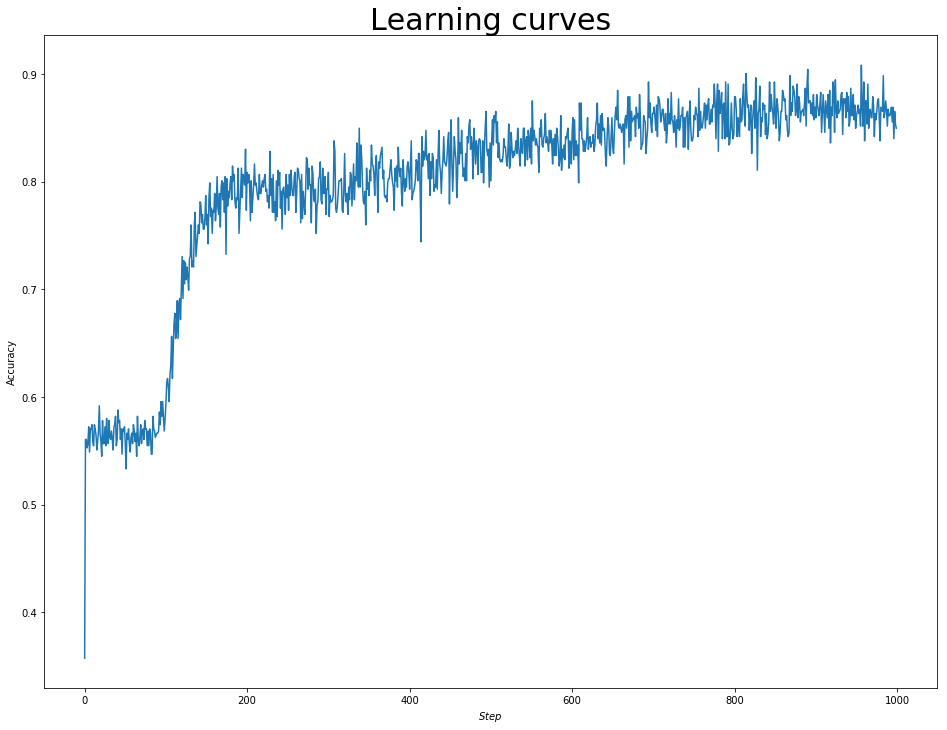

In [33]:
simple_plot(ah, 'Accuracy')

In [34]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [35]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [36]:
acc_test

0.802725968436155